# EXPERIMENT 2: Adding a fully connected layer

In [3]:
import torch 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from src.loss import YoloLoss
from src.YOLOv1 import YOLO
from src.train import train
from src.test import test
from src.utils import plot_bbox, get_boxes, convert_dict
import time
from src.dataset import AfricanWildlifeDataset

In [4]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
torch.device('cuda')
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 5
EPOCHS = 0
TRAIN_DIR = 'African_Wildlife/train'
TEST_DIR = 'African_Wildlife/test'
LABEL_DIR = 'African_Wildlife/annotations'
S, B, C = 7, 2, 4

# Three fully connected layers

In [5]:
# load the data
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(), transforms.Normalize([0.5200, 0.4957, 0.4068],[0.2391, 0.2283, 0.2303])])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

In [7]:
# model
model = YOLO(input_channels=3, S=S, B=B, C=C, fc=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

In [8]:
start_time = time.time()
loss_hist = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE,
                  ckpt_filename='experiment_2/three_fc.tar', load_model=True, 
                  save_epochs=5)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 

-> Loading checkpoint
Elapsed time:  5.2326178550720215


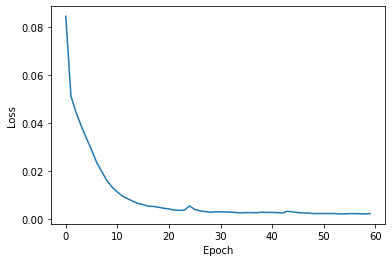

In [9]:
import matplotlib.pyplot as plt

exp = torch.load('experiment_2/three_fc.tar')
loss_history = exp["loss_history"]
plt.plot(range(len(loss_history)), loss_history) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [10]:
# testing 
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.6, True])
# non-max-suppression
pred_boxes, true_boxes = get_boxes(y_pred, y_true, iou_threshold=0.5)

pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

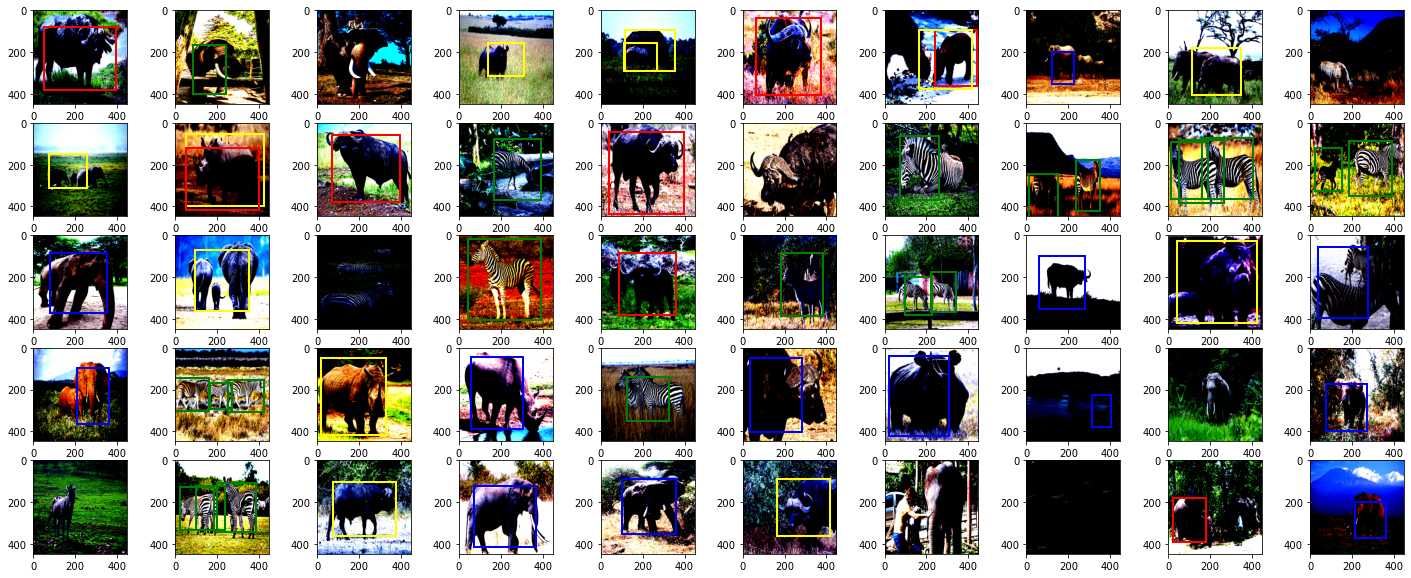

In [11]:
# plot predictions
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [12]:
# map
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])
    
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)
m_ap.update(predictions, target)
ap1 = m_ap.compute()

In [13]:
ap1

{'map': tensor(0.1139),
 'map_50': tensor(0.2687),
 'map_75': tensor(0.0775),
 'map_small': tensor(0.1139),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1337),
 'mar_10': tensor(0.1585),
 'mar_100': tensor(0.1585),
 'mar_small': tensor(0.1585),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}